In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

from yellowbrick.cluster import silhouette_visualizer
import plotly.express as px
import seaborn as sns

### librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [75]:
rdb = pd.read_csv('./DATA_RDB.csv', na_values=['(null)'], encoding='unicode_escape')

In [76]:
# Remove commas and leading/trailing whitespaces from the 'ARENOSA_RED_FLOWRATE' column
rdb['ARENOSA_RED_FLOWRATE'] = rdb['ARENOSA_RED_FLOWRATE'].str.replace(',', '').str.strip()

# Convert the cleaned column to the float data type
rdb['ARENOSA_RED_FLOWRATE'] = rdb['ARENOSA_RED_FLOWRATE'].astype(float)

In [77]:
rdb_c = rdb[['DateTime','TFLORESRDB_V_PRES_L12', 'CRA46_V_PRES',
       '7DEABRIL1_STAPRE_LIVE', 'CALLE30_V_PRES', 'ARENOSA_RED_PRESION',
       'ARENOSA_RED_FLOWRATE']].copy()
#rdb.drop(columns=['DateTime'])

In [78]:
#rdb_c2= rdb_c[rdb_c['ARENOSA_RED_PRESION'] >= 248]
#Me quedo con los datos en que la presión de entrada está en el rango de operación normal
#rdb_c2 = rdb_c[(rdb_c['ARENOSA_RED_PRESION'] >= 248) & (rdb_c['ARENOSA_RED_PRESION'] <= 252)]
rdb_c2 = rdb_c.copy()

#Guardo la fecha 
rdb_date = rdb_c2['DateTime']

#Borro date time debido a que no la debo tener en cuenta para el clustering y la normalización
rdb_c2 = rdb_c2.drop(columns=['DateTime'])

#Normalizó los datos filtrados
rdb_nor = preprocessing.scale(rdb_c2)

Text(0.5, 0, 'Número de clusters')

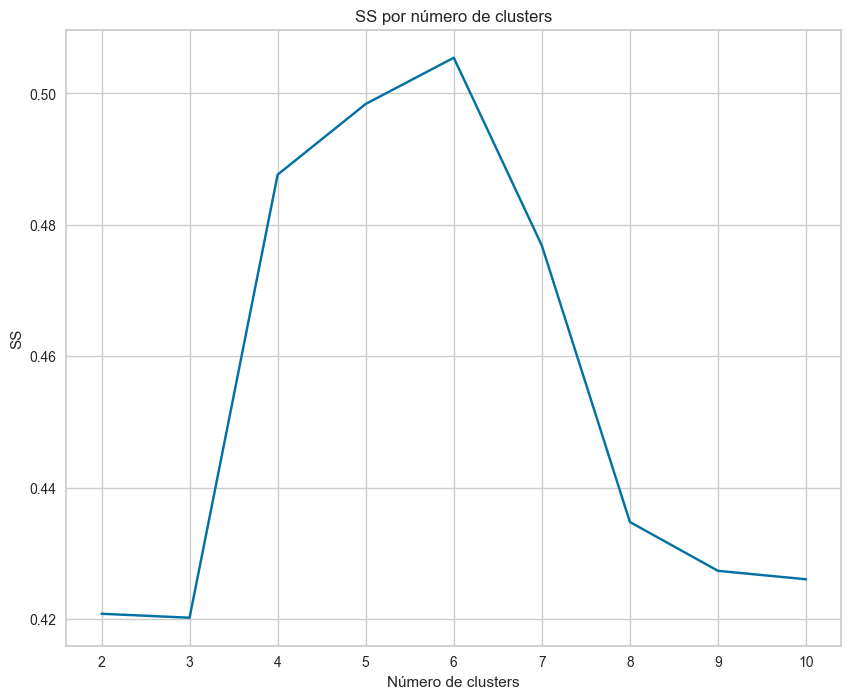

In [79]:
plt.figure(figsize=(10,8))
ss =[]
maxRange = 11
for i in range(2,maxRange):
  kmeans = KMeans(n_clusters=i, init='k-means++')
  kmeans.fit(rdb_nor)
  ss.append(silhouette_score(rdb_nor, kmeans.labels_))
plt.plot(range(2,maxRange), ss)
plt.title('SS por número de clusters')
plt.ylabel('SS')
plt.xlabel('Número de clusters')

In [80]:
#Escojo un modelo de 2 cluster por tener el mayor ss
kmeans = KMeans(n_clusters=2, init='k-means++')
model = kmeans.fit(rdb_nor)

#Guardo los clusters en el rdb recodificado
rdb_c2['Cluster'] = model.labels_
rdb_c2['DateTime'] = rdb_date

#Guardo los clusters en el rdb codificado
#rdb_nor['Cluster'] = model.labels_
#rdb_nor['DateTime'] = rdb_date


In [81]:
rdb_c2.groupby(['Cluster']).describe()['ARENOSA_RED_FLOWRATE']

count         mean         std      min       25%      50%  \
Cluster                                                                
0        3134.0  2007.024681  254.911738  1039.73  1827.880  1989.62   
1        5323.0  1389.503205  326.648731   325.97  1148.525  1350.72   

               75%      max  
Cluster                      
0        2179.1525  2903.12  
1        1654.4550  2474.52

In [82]:
rdb_c2.groupby(['Cluster']).describe()['TFLORESRDB_V_PRES_L12']

count        mean       std     min     25%     50%       75%  \
Cluster                                                                   
0        3134.0  227.613829  4.103860  209.66  225.36  228.23  230.7725   
1        5323.0  237.510768  3.125394  229.83  234.94  237.49  240.0400   

            max  
Cluster          
0        237.49  
1        245.15

In [83]:
rdb_c2[rdb_c2['Cluster'] == 1]

TFLORESRDB_V_PRES_L12  CRA46_V_PRES  7DEABRIL1_STAPRE_LIVE  \
0                    241.64        244.23                 241.70   
1                    241.64        244.10                 241.70   
2                    241.64        243.84                 241.63   
3                    241.64        244.48                 241.54   
4                    242.60        244.10                 241.44   
...                     ...           ...                    ...   
8452                 240.36        242.95                 242.28   
8453                 240.36        243.14                 242.28   
8454                 241.32        242.63                 243.34   
8455                 241.32        242.63                 243.34   
8456                 240.36        243.25                 243.34   

      CALLE30_V_PRES  ARENOSA_RED_PRESION  ARENOSA_RED_FLOWRATE  Cluster  \
0             247.63               249.93               1105.86        1   
1             247.50               249.99               1076.74        1   
2             247.57               249.93               1062.49        1   
3             247.57               249.95               1105.36        1   
4             247.63               249.98               1033.96        1   
...              ...                  ...                   ...      ...   
8452          246.70               250.01               1310.60        1   
8453          246.48               250.04               1355.02        1   
8454          246.80               250.02               1289.51        1   
8455          246.71               250.02               1242.78        1   
8456          246.80               250.02               1257.02        1   

              DateTime  
0       1/11/2023 0:15  
1       1/11/2023 0:30  
2       1/11/2023 0:45  
3       1/11/2023 1:00  
4       1/11/2023 1:15  
...                ...  
8452  30/01/2024 22:45  
8453  30/01/2024 23:00  
8454  30/01/2024 23:30  
8455  30/01/2024 23:45  
8456   31/01/2024 0:00  

[5323 rows x 8 columns]

In [84]:
px.scatter(rdb_c2,y='TFLORESRDB_V_PRES_L12', x='ARENOSA_RED_FLOWRATE', color='Cluster', hover_data='DateTime')

In [85]:
px.scatter(rdb_nor,y=1, x=0)

In [86]:
px.scatter(rdb_c2, y='ARENOSA_RED_PRESION', color='Cluster', hover_data='DateTime')

In [87]:
px.scatter(rdb_c2, y='TFLORESRDB_V_PRES_L12', color='Cluster', hover_data='DateTime')

In [88]:
px.scatter(rdb_c2, y='ARENOSA_RED_FLOWRATE', color='Cluster', hover_data='DateTime')

In [89]:
px.scatter(rdb_c2, y='CRA46_V_PRES', color='Cluster', hover_data='DateTime')

In [104]:
rdb_c2.columns

Index(['TFLORESRDB_V_PRES_L12', 'CRA46_V_PRES', '7DEABRIL1_STAPRE_LIVE',
       'CALLE30_V_PRES', 'ARENOSA_RED_PRESION', 'ARENOSA_RED_FLOWRATE',
       'Cluster', 'DateTime'],
      dtype='object')

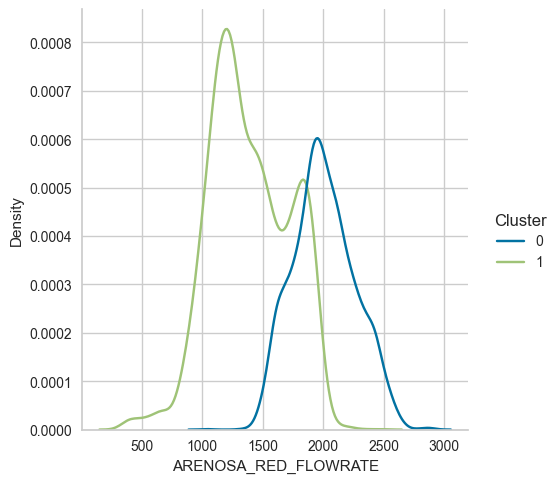

In [106]:
sns.displot(data=rdb_c2, x="ARENOSA_RED_FLOWRATE", hue="Cluster", kind="kde")

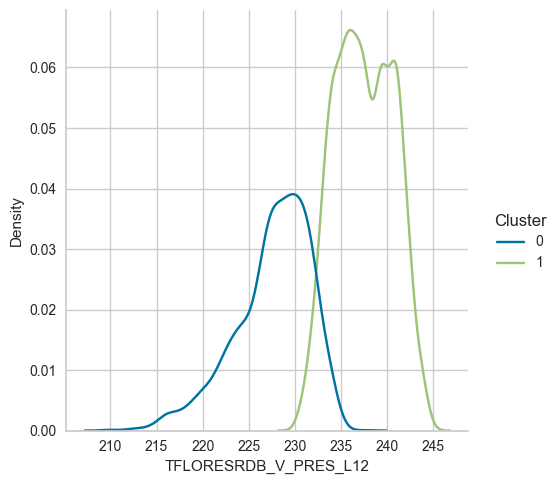

In [107]:
sns.displot(data=rdb_c2, x="TFLORESRDB_V_PRES_L12", hue="Cluster", kind="kde")

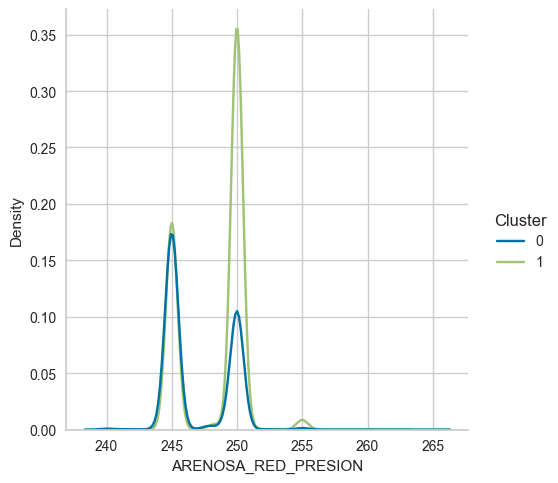

In [105]:
sns.displot(data=rdb_c2, x="ARENOSA_RED_PRESION", hue="Cluster", kind="kde")

## CLASSIFICACTION

In [90]:
X, y = rdb_c2.drop(columns=["Cluster", 'DateTime']), rdb_c2["Cluster"]

In [91]:
# inicialmente se tiene un logit con todas las variables
#logit_full = sm.Logit(y, X).fit()
#print(logit_full.summary())

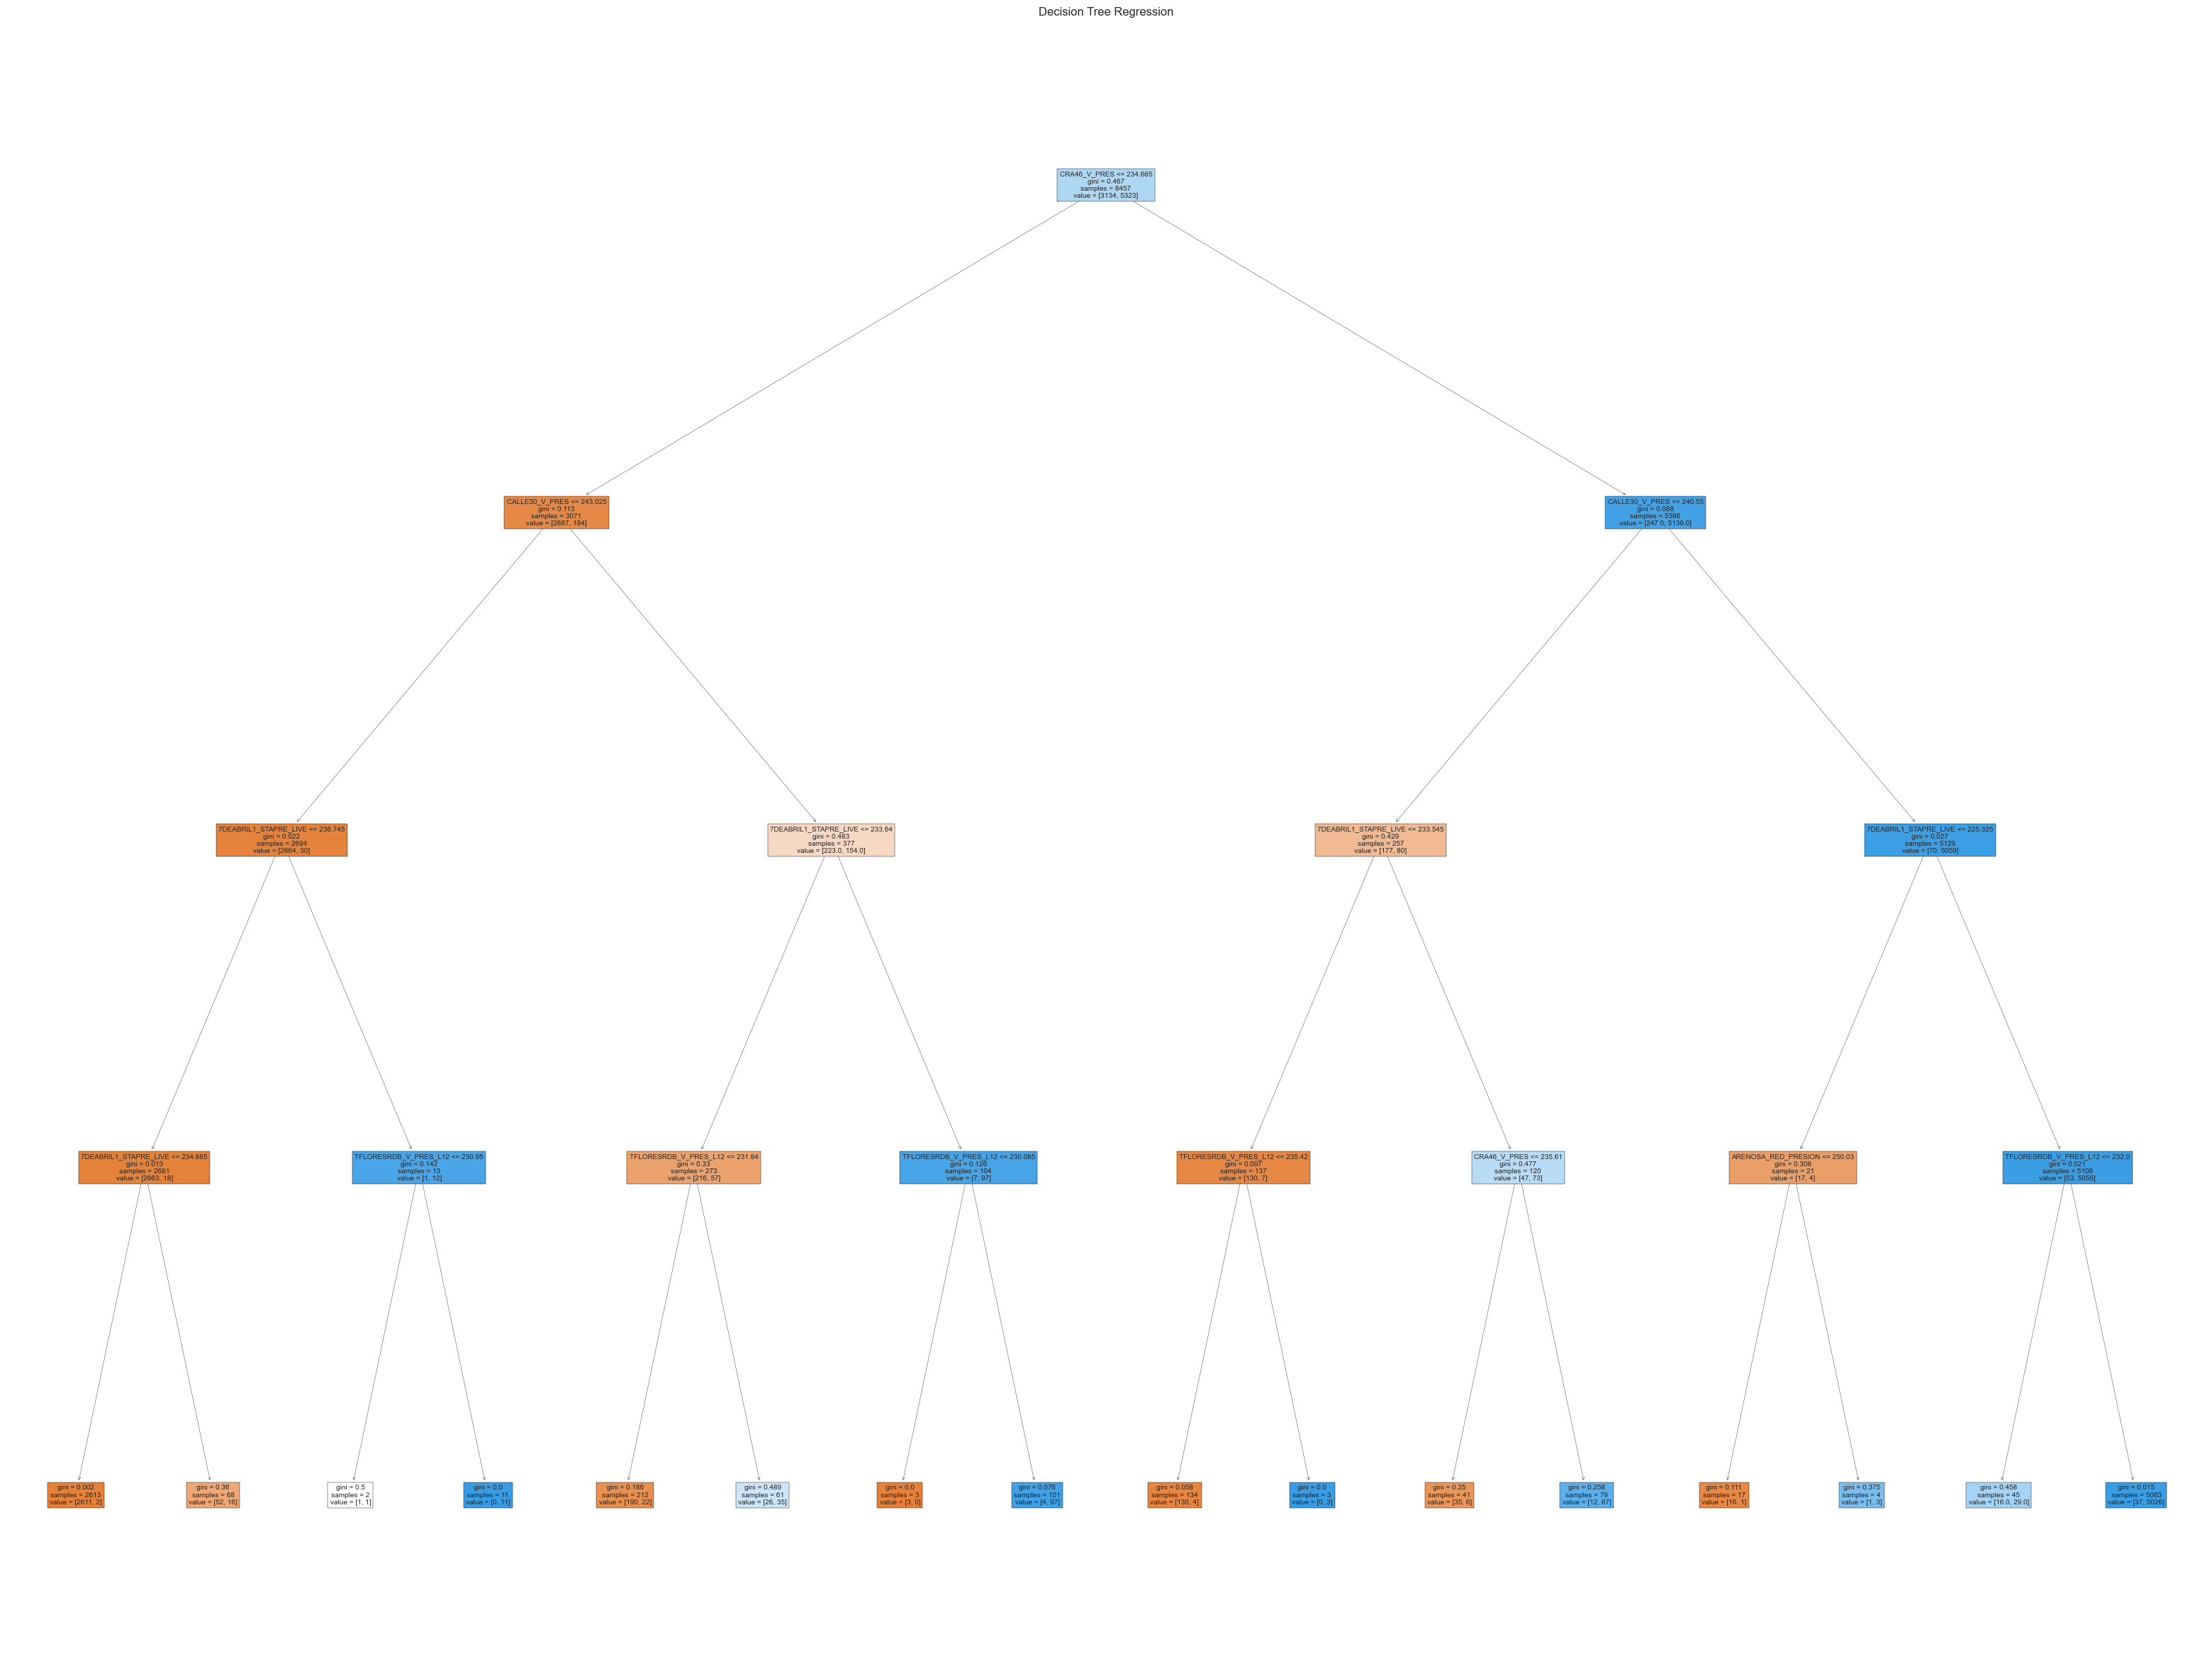

In [92]:
## Como exploración adicional se crea un arbol de decisión
dcstree = DecisionTreeClassifier(max_depth=4)
dcstree.fit(X, y)

plt.figure(figsize=(40, 30))
tree.plot_tree(dcstree, feature_names=X.columns, filled=True)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.show()

In [98]:
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=123)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)


In [99]:
# Definir los modelos
models = {
    #'Logistic Regression': LogisticRegression(solver='liblinear'),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

# Definir los parámetros a ajustar para cada modelo
params = {
    #'Logistic Regression': {'C': [0.1, 1, 10]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001]},
    'Decision Tree': {'max_depth': [2, 3, 5, 10]},
    'Random Forest': {'n_estimators': [10, 50, 100], 'max_depth': [2, 3, 10, 50]},
    'XGBoost': {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [2, 3, 5, 10]}
}

# Se evalúa cada modelo utilizando Grid Search
grid_results = []
best_models = {}
for name, model in models.items():
    #Estimators have a scor method providing a default evaluation criterion for the problem they are designed to solve
    #grid_search = GridSearchCV(model, params[name], cv=5, scoring=['accuracy', 'f1', 'recall'], refit = 'f1') 
    grid_search = GridSearchCV(model, params[name], cv=5) 
    grid_search.fit(Xtrain, ytrain)
    best_models[name] = grid_search.best_estimator_
    grid_results.append({"name": name ,"hyperparameters":grid_search.best_params_, "score": grid_search.best_score_ , "model": grid_search.best_estimator_ })

best_model_report = pd.DataFrame(grid_results).sort_values(by="score", ascending=False)
best_model_report

name                          hyperparameters     score  \
3        XGBoost  {'learning_rate': 0.1, 'max_depth': 10}  0.992018   
2  Random Forest   {'max_depth': 50, 'n_estimators': 100}  0.991279   
0            SVM                 {'C': 10, 'gamma': 0.01}  0.985218   
1  Decision Tree                        {'max_depth': 10}  0.983296   

                                               model  
3  XGBClassifier(base_score=None, booster=None, c...  
2  (DecisionTreeClassifier(max_depth=50, max_feat...  
0                              SVC(C=10, gamma=0.01)  
1               DecisionTreeClassifier(max_depth=10)

In [100]:
best_model = max(grid_results, key= lambda x: x['score'])
best_model = best_model['model']
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2527
           1       1.00      1.00      1.00      4238

    accuracy                           1.00      6765
   macro avg       1.00      1.00      1.00      6765
weighted avg       1.00      1.00      1.00      6765



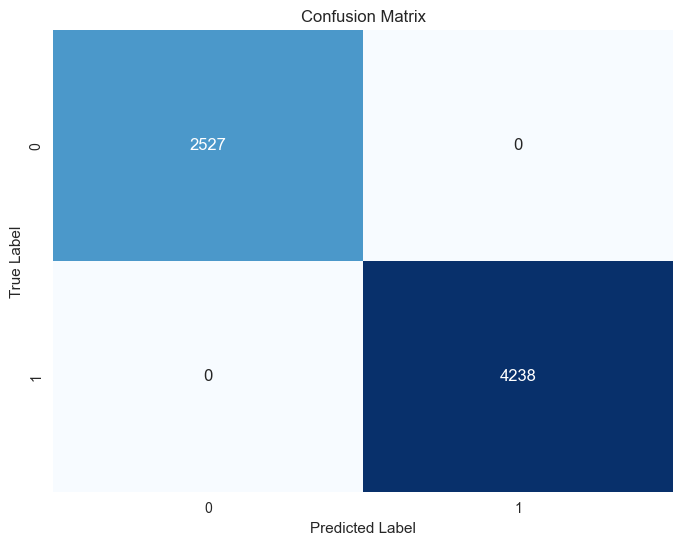

In [101]:
modelof = best_model.fit(Xtrain, ytrain)
ypredict = modelof.predict(Xtrain)
modelof.score(Xtrain, ytrain)
print(metrics.classification_report(ytrain, ypredict))
conf_matrix = metrics.confusion_matrix(ytrain, ypredict)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       607
           1       1.00      1.00      1.00      1085

    accuracy                           1.00      1692
   macro avg       1.00      1.00      1.00      1692
weighted avg       1.00      1.00      1.00      1692



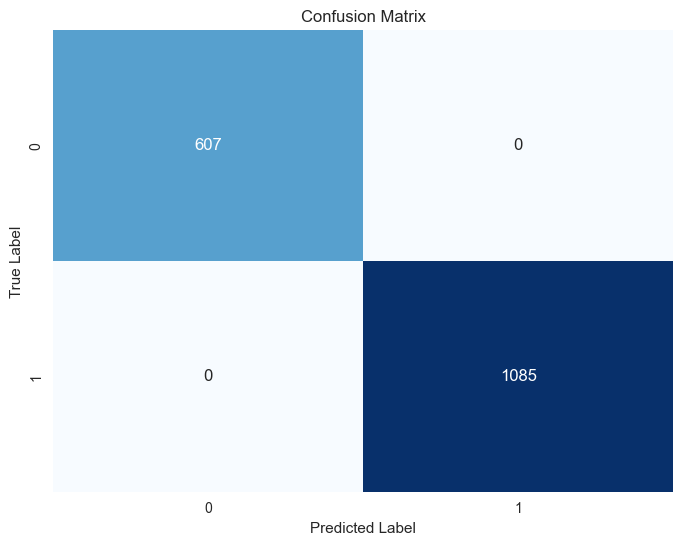

In [102]:
modelof = best_model.fit(Xtest, ytest)
ypredict = modelof.predict(Xtest)
modelof.score(Xtest, ytest)
print(metrics.classification_report(ytest, ytest))
conf_matrix = metrics.confusion_matrix(ytest, ytest)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()